## Before you read:

#### Note that the GloVe pretrained vector embeddings were used in this project. You can download the embeddings [here](http://nlp.stanford.edu/data/glove.6B.zip)

In [34]:
import pandas as pd 
import numpy as np

from keras.models import Sequential
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [4]:
filepath_dict = {'yelp': './data/yelp_labelled.txt',
                'amazon' : './data/amazon_cells_labelled.txt',
                'imdb' : './data/imdb_labelled.txt'}
df_list = []
for source,path in filepath_dict.items():
    df = pd.read_csv(path, names = ['sentence', 'label'], sep= '\t')
    df['source'] = source
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In [6]:
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train,sentences_test,y_train,y_test = train_test_split(sentences,y,test_size=0.25,random_state=1000)

print('Training set: {} '.format(len(sentences_train)))
print('Testing set: {} '.format(len(sentences_test)))

Training set: 750 
Testing set: 250 


In [24]:
# so in order to embed the words they first need to be tokenized (pre-processed)
tokenizer = Tokenizer(num_words=5000)
# this fills the dictionry of 5000 words with the words from the 750 yelp reviews
tokenizer.fit_on_texts(sentences_train)

# creates the vector representation of the sentences where each element is the index of that word in the dictionry
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  #reserves 0 index

print("Vocab Size: ", vocab_size)
print(X_train[1])
print(sentences_train[1])

Vocab Size:  1747
[740, 4, 46, 12, 20, 160, 10, 72, 35, 355, 232]
Sorry, I will not be getting food from here anytime soon :(


In [26]:
# again we make all feature vectors the same size here
maxlen = 100

X_train = pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test = pad_sequences(X_test,padding='post',maxlen=maxlen)

print(X_train[1])

[740   4  46  12  20 160  10  72  35 355 232   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [27]:
# we are only going to use the words in GloVe that are actually in out training set
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [28]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('/Users/elidangerfield/Desktop/glove.6B/glove.6B.50d.txt',
                                           tokenizer.word_index, 
                                           embedding_dim)

In [29]:
# so now we have 1747 words with a 50 dimension vector representation (if it existed already) courtesy of GloVe :)
embedding_matrix.shape

(1747, 50)

In [30]:
# however there is a problem: GloVe didnt have every single one of our words. Infact it missed 86 of them
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
vocab_size - nonzero_elements
# two roads diverge in a yellow wood of statistics and data analysis here: Keep the data? or Leave the data?
# I am choosing to keep it but we can come back and see what happens if we leave it or if we can fix the zero's

86

In [43]:
model = Sequential()
# I explicitly allow for training for the word embeddings given by GloVe
# this will hep with the zeros found in the embedding matrix, doing this increased test accuracy by 7%
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
# the output at this point is 100 50dim vectors where each vector is a word in the 100 word (padded) review
model.add(layers.GlobalMaxPool1D())
#max pooling reduced every 50dim vector to 1d so now we have 100 1d vectors
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 750 samples, validate on 250 samples
Epoch 1/50
750/750 [==============================] - 3s 4ms/step - loss: 0.7353 - acc: 0.4880 - val_loss: 0.6953 - val_acc: 0.4760
Epoch 2/50
750/750 [==============================] - 1s 1ms/step - loss: 0.6837 - acc: 0.5640 - val_loss: 0.6880 - val_acc: 0.5760
Epoch 3/50
750/750 [==============================] - 1s 1ms/step - loss: 0.6683 - acc: 0.6160 - val_loss: 0.6809 - val_acc: 0.6080
Epoch 4/50
750/750 [==============================] - 1s 1ms/step - loss: 0.6499 - acc: 0.6893 - val_loss: 0.6701 - val_acc: 0.6200
Epoch 5/50
750/750 [==============================] - 1s 1ms/step - loss: 0.6245 - acc: 0.7453 - val_loss: 0.6567 - val_acc: 0.6520
Epoch 6/50
750/750 [==============================] - 1s 1ms/step - loss: 0.5932 - acc: 0.7813 - val_loss: 0.6407 - val_acc: 0.6600
Epoch 7/50
750/750 [==============================] - 1s 1ms/step - loss: 0.5514 - a

In [37]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 1.0000
Testing Accuracy:  0.7720


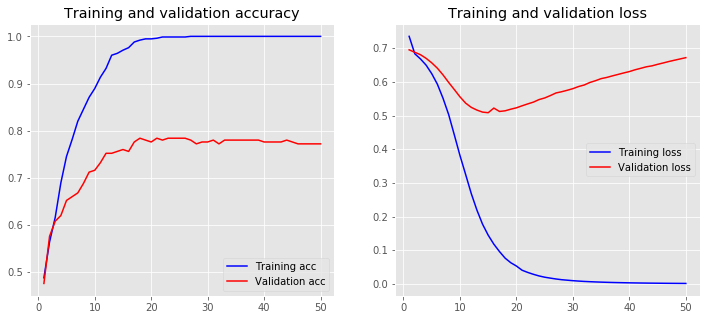

In [46]:
plot_history(history)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [47]:
# as you can see again, our model has overfit to the training set with 100% accuracy. 
# now lets see how our model using pretrained word embeddings does on all of our test sets
for source in df['source'].unique():
    
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values
    
    #preprocess X in the same way we did for our model
    X = tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(X,padding='post',maxlen=maxlen)
    
    loss, accuracy = model.evaluate(X, y, verbose=False)
    
    print('Accuracy for ',source,' data: ', accuracy)


Accuracy for  yelp  data:  0.943
Accuracy for  amazon  data:  0.72
Accuracy for  imdb  data:  0.7125668449197861


In [ ]:
# this is actually just slightly worse than training our own embeddings